In [1]:
import numpy as np
import random
import math
import sys
import os
#import cv2
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import train_test_split
from shutil import copy
from sklearn.metrics import confusion_matrix
import time

pre-process the images, check the image size for different models

In [13]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

BATCH_SIZE = 32

path1 = "./Dataset"

classes = ['0', '1', '2', '3', '4', '5','6','7','8','9']
n_classes = len(classes)

def data_loader(root=path1):
        # Define image transforms
    train_transform = transforms.Compose([
            #transforms.RandomHorizontalFlip(),
            transforms.Grayscale(),
            #transforms.RandomRotation(10),
            #transforms.Resize((224,224)),
            #transforms.Resize((7,7)),
            transforms.Resize((28,28)),
            transforms.ToTensor(),
            #transforms.Normalize([0.5, 0.5, 0.5],     # standard normalization values
             #                    [0.5, 0.5, 0.5])
            ])   

    test_transform = transforms.Compose([
            #transforms.RandomHorizontalFlip(),
            transforms.Grayscale(),
            #transforms.Resize((224,224)),
            #transforms.Resize((7,7)),
            transforms.Resize((28,28)),
            transforms.ToTensor(),
            #transforms.Normalize([0.5, 0.5, 0.5],     # standard normalization values
             #                    [0.5, 0.5, 0.5])
            ])

    train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
    test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)


    #train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
    #test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
    
    return train_loader, test_loader

train_loader, test_loader = data_loader(root=path1)

In [ ]:
n = 20
cnt = 0

for m, (X_train, y_train) in enumerate(train_loader): 
    #if m == n:
        #print(X_train)
        #print(y_train)
    if cnt>=1: 
        break    
    img = X_train[0]   
    img = img.numpy()   
    img = np.transpose(img, (1,2,0))    

    plt.imshow(img)
    plt.show()
    print(X_train*255)
    print(y_train)
    print(X_train.shape)
    print(y_train.shape)
    cnt += 1
        

train function

In [4]:
import sklearn 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def train_model(CNNmodel,epochs,train_loader,test_loader,criterion,optimizer,Batch_Size=20,print_every = 10, 
                LEARNING_RATE=0.001, lr_reduce=50, verbose=True,plot_results=True):
    
    start_time = time.time()
    batch_size = Batch_Size
    max_trn_batch = 800  # Limits very large datasets
    max_tst_batch = 300
    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []
    losses=[]
    
    print('Training for {} epochs...\n'.format(epochs))
    
    for epoch in range(epochs):
        trn_corr = 0
        tst_corr = 0
        trn_loss = 0
        tst_loss = 0
        for m, (X_train, y_train) in enumerate(train_loader): # Run the training batches
            # Limit the number of batches
            if m == max_trn_batch: break
            m+=1

            y_pred = CNNmodel(X_train)  # Apply the model
            loss = criterion(y_pred, y_train)
            
            predicted = torch.max(y_pred.data, 1)[1] # Tally the number of correct predictions
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            optimizer.zero_grad()  # Update parameters
            loss.backward()
            optimizer.step()
            
            trn_loss += loss.item()
            
        train_losses.append(trn_loss)
        train_correct.append(trn_corr*100/(batch_size*m))

        with torch.no_grad():  # Run the testing batches
            for n, (X_test, y_test) in enumerate(test_loader):
                if n == max_tst_batch: break  # Limit the number of batches

                y_val = CNNmodel(X_test)  # Apply the model
                loss = criterion(y_val, y_test)
                tst_loss += loss.item()

                predicted = torch.max(y_val.data, 1)[1]  # Tally the number of correct predictions
                tst_corr += (predicted == y_test).sum()

        test_losses.append(tst_loss)
        test_correct.append(tst_corr*100/(batch_size*n))

        if verbose == True and epoch % print_every== 0: 
            print('\n\nEpoch {}/{}: train loss: {:.4f} | acc: {:.4f}%|   validation loss: {:.4f} | acc: {:.4f}%'
                  .format(epoch+1, epochs, trn_loss, trn_corr*100/(batch_size*m), tst_loss, tst_corr*100/(batch_size*n)), end=' ')
        if epoch+1 == epochs:
            print('\n\nFinal Accuracy:{:.4f}%'.format( tst_corr*100/(batch_size*n)))
            
                # adjust the LEARNING_RATE
        if epoch != 0 and epoch % lr_reduce == 0:
            LEARNING_RATE = LEARNING_RATE*0.5
            optimizer = optim.Adam(CNNmodel.parameters(),lr = LEARNING_RATE)
#            for param_group in optimizer.param_groups:
#                param_group['lr'] = LEARNING_RATE
            print('\n\n\nEpoch{}/{}: Set LEARNING_RATE = {:.8f}'.format(epoch+1, epochs, LEARNING_RATE))
    
        
    if verbose == True:        
        print('\nFinished Training  | Time:{}'.format(time.time()-start_time))
    if plot_results == True:
        plt.figure(figsize=(10,10))
        plt.plot(train_losses, label='train loss')
        plt.plot(test_losses, label='validation loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.draw()
        
        plt.figure(figsize=(10,10))
        plt.plot([t for t in train_correct], label='train accuracy')
        plt.plot([t for t in test_correct], label='validation accuracy')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.draw()
        
        return CNNmodel
    

model with stride approach for input size (140,140), (168,168), (196,196), (56,56), (42,42) and (28,28)

In [5]:
import onnx
import torch
from brevitas.nn import QuantConv2d, QuantIdentity, QuantMaxPool2d, QuantLinear,QuantDropout,QuantReLU
from brevitas.core.quant import QuantType
import torch.nn as nn
from torch import optim
from brevitas.quant import SignedTernaryActPerTensorConst,SignedBinaryActPerTensorConst
import brevitas.onnx as bo

Training for 10 epochs...



/opt/conda/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(




Epoch 1/10: train loss: 521.3015 | acc: 79.9141%|   validation loss: 105.5620 | acc: 88.9271% 

Epoch 6/10: train loss: 140.6314 | acc: 94.3203%|   validation loss: 50.8183 | acc: 94.9167% 

Final Accuracy:95.3750%

Finished Training  | Time:5053.366275072098


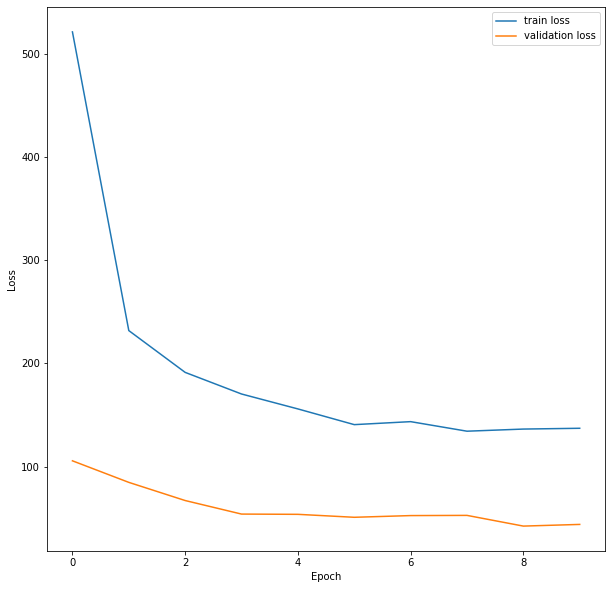

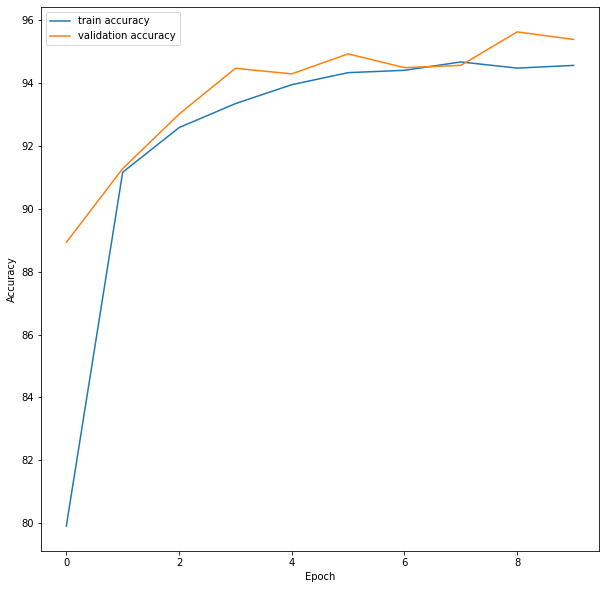

In [7]:
# mAlexNet (140,140)

# did not change the architecture, but changed the kernel size and channels


class MNIST_2D(nn.Module):
    def __init__(self,input_size,num_classes,weight_bit_width,act_bit_width):
        super(MNIST_2D,self).__init__()
        
        self.cnn1 = QuantConv2d(in_channels=input_size,out_channels=16,kernel_size=3,
                                padding=1,bias=False,weight_bit_width=weight_bit_width)
        self.bn_1 = nn.BatchNorm2d(16)
        self.relu1 = QuantReLU(bit_width=act_bit_width)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn2 = QuantConv2d(in_channels=16,out_channels=20,kernel_size=3,
                                padding=0,bias=False,weight_bit_width=weight_bit_width)
        self.bn_2 = nn.BatchNorm2d(20)
        self.relu2 = QuantReLU(bit_width=act_bit_width)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn3 = QuantConv2d(in_channels=20,out_channels=30,kernel_size=3, stride=(3,3),
                               padding=1,bias=False,weight_bit_width=weight_bit_width)
        self.relu3 = QuantReLU(bit_width=act_bit_width)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=None)

        self.drop1 = QuantDropout(p=0.5)
                                  
        self.fc1 = QuantLinear(6*6*30,2*30,bias=False,weight_bit_width=weight_bit_width)
        self.relu4 = QuantReLU(bit_width=act_bit_width)
        
        self.fc2 = QuantLinear(30*2,num_classes,bias=False,weight_bit_width=weight_bit_width)
        
    def forward(self,x):
        x = self.maxpool1(self.relu1(self.bn_1(self.cnn1(x))))
        x = self.maxpool2(self.relu2(self.bn_2(self.cnn2(x))))
        x = self.maxpool3(self.relu3(self.cnn3(x)))
        
        x = x.view(x.size(0),-1)
        x = self.drop1(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
input_size = 1 # 3 input layers for RGB image
num_classes = n_classes
weight_bit_width = 2
act_bit_width = 2

brevitas_model = MNIST_2D(input_size=input_size,num_classes=num_classes,
                                    weight_bit_width=weight_bit_width,act_bit_width=act_bit_width)

LEARNING_RATE = 0.0004
optimizer = optim.Adam(brevitas_model.parameters(),lr = LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

train_loader, test_loader = data_loader(root=path1)

EPOCHS=10
lr_reduce=30
trained_classifier = train_model(CNNmodel=brevitas_model,epochs=EPOCHS,
                                train_loader=train_loader, test_loader=test_loader,
                                criterion = criterion,optimizer = optimizer, 
                                Batch_Size = BATCH_SIZE,print_every = 5, 
                                LEARNING_RATE=LEARNING_RATE, lr_reduce=lr_reduce,
                                verbose=True,plot_results=True)

torch.save(brevitas_model.state_dict(),'./multi_model_test/save_model/model_2D_parameter_140_140_s.pth')

export_onnx_path="./multi_model_test/save_model/model_2D_140_140_s.onnx"
input_shape=(1,1,140,140)
bo.export_finn_onnx(brevitas_model, input_shape, export_onnx_path)

In [ ]:
torch.save(brevitas_model.state_dict(),'./multi_model_test/save_model/model_2D_parameter_140_140_s.pth')

export_onnx_path="./multi_model_test/save_model/model_2D_140_140_s.onnx"
input_shape=(1,1,140,140)
bo.export_finn_onnx(brevitas_model, input_shape, export_onnx_path)

Training for 10 epochs...



Epoch 1/10: train loss: 401.9396 | acc: 84.0547%|   validation loss: 71.1175 | acc: 92.9062% 

Epoch 6/10: train loss: 122.5275 | acc: 95.1562%|   validation loss: 39.7738 | acc: 95.8958% 

Final Accuracy:96.0521%

Finished Training  | Time:7229.3831424713135


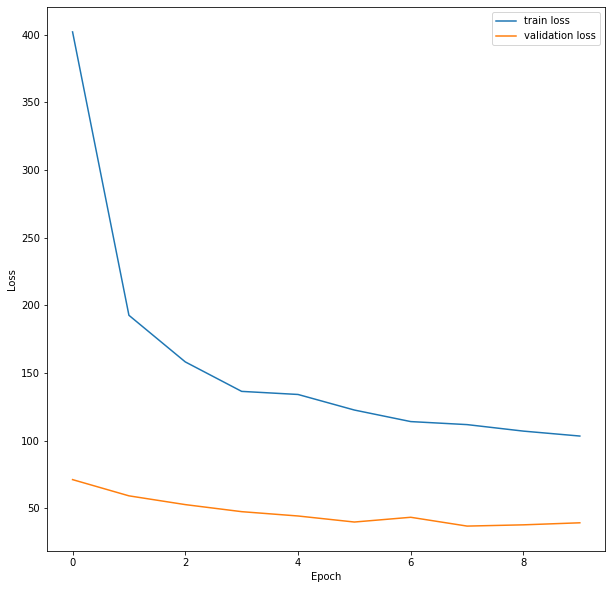

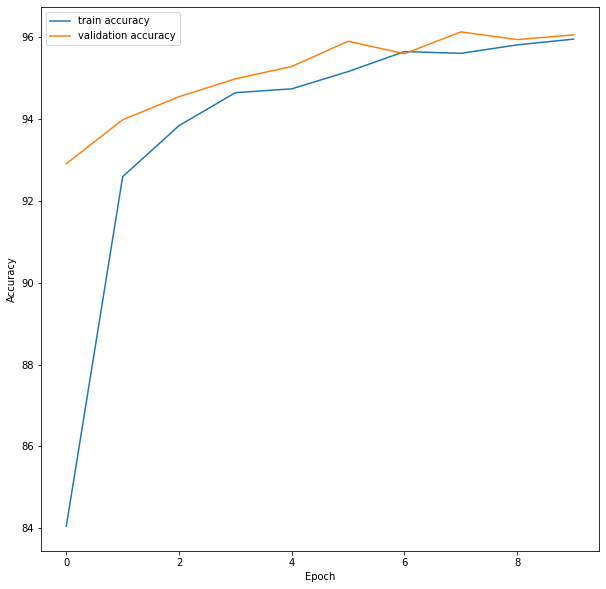

In [11]:
# mAlexNet (168,168)

# did not change the architecture, but changed the kernel size and channels


class MNIST_2D(nn.Module):
    def __init__(self,input_size,num_classes,weight_bit_width,act_bit_width):
        super(MNIST_2D,self).__init__()
        
        self.cnn1 = QuantConv2d(in_channels=input_size,out_channels=16,kernel_size=3,
                                padding=1,bias=False,weight_bit_width=weight_bit_width)
        self.bn_1 = nn.BatchNorm2d(16)
        self.relu1 = QuantReLU(bit_width=act_bit_width)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn2 = QuantConv2d(in_channels=16,out_channels=20,kernel_size=3,
                                padding=1,bias=False,weight_bit_width=weight_bit_width)
        self.bn_2 = nn.BatchNorm2d(20)
        self.relu2 = QuantReLU(bit_width=act_bit_width)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn3 = QuantConv2d(in_channels=20,out_channels=30,kernel_size=3, stride=(3,3),
                               padding=0,bias=False,weight_bit_width=weight_bit_width)
        self.relu3 = QuantReLU(bit_width=act_bit_width)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=None)

        self.drop1 = QuantDropout(p=0.5)
                                  
        self.fc1 = QuantLinear(7*7*30,2*30,bias=False,weight_bit_width=weight_bit_width)
        self.relu4 = QuantReLU(bit_width=act_bit_width)
        
        self.fc2 = QuantLinear(30*2,num_classes,bias=False,weight_bit_width=weight_bit_width)
        
    def forward(self,x):
        x = self.maxpool1(self.relu1(self.bn_1(self.cnn1(x))))
        x = self.maxpool2(self.relu2(self.bn_2(self.cnn2(x))))
        x = self.maxpool3(self.relu3(self.cnn3(x)))
        
        x = x.view(x.size(0),-1)
        x = self.drop1(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
input_size = 1 # 3 input layers for RGB image
num_classes = n_classes
weight_bit_width = 2
act_bit_width = 2

brevitas_model = MNIST_2D(input_size=input_size,num_classes=num_classes,
                                    weight_bit_width=weight_bit_width,act_bit_width=act_bit_width)

LEARNING_RATE = 0.0004
optimizer = optim.Adam(brevitas_model.parameters(),lr = LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

train_loader, test_loader = data_loader(root=path1)

EPOCHS=10
lr_reduce=30
trained_classifier = train_model(CNNmodel=brevitas_model,epochs=EPOCHS,
                                train_loader=train_loader, test_loader=test_loader,
                                criterion = criterion,optimizer = optimizer, 
                                Batch_Size = BATCH_SIZE,print_every = 5, 
                                LEARNING_RATE=LEARNING_RATE, lr_reduce=lr_reduce,
                                verbose=True,plot_results=True)

torch.save(brevitas_model.state_dict(),'./multi_model_test/save_model/model_2D_parameter_168_168_s.pth')

export_onnx_path="./multi_model_test/save_model/model_2D_168_168_s.onnx"
input_shape=(1,1,168,168)
bo.export_finn_onnx(brevitas_model, input_shape, export_onnx_path)

Training for 10 epochs...



/opt/conda/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(




Epoch 1/10: train loss: 368.7008 | acc: 85.1797%|   validation loss: 75.5381 | acc: 92.2292% 

Epoch 6/10: train loss: 125.1989 | acc: 95.1016%|   validation loss: 39.8938 | acc: 95.6667% 

Final Accuracy:95.3958%

Finished Training  | Time:10544.541678190231


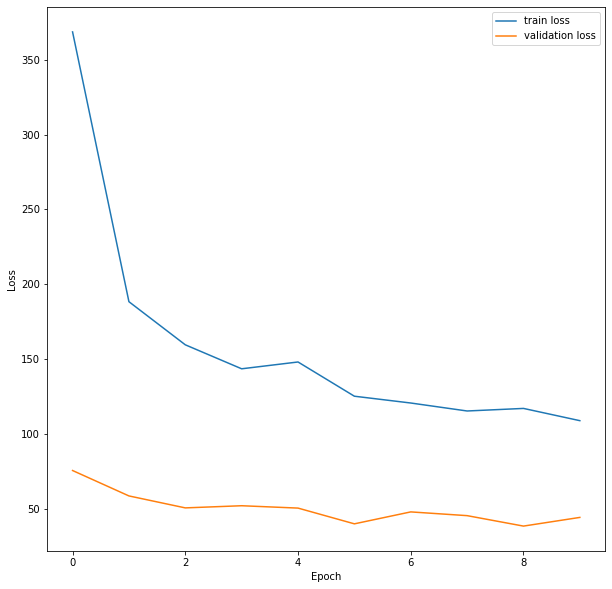

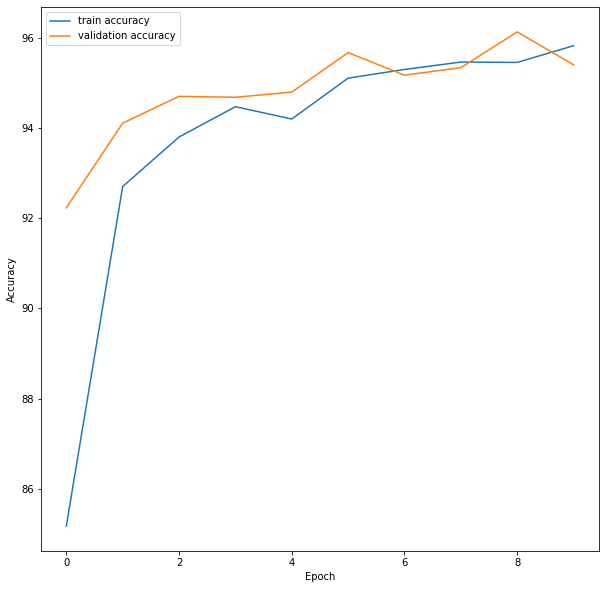

In [7]:
# mAlexNet (196,196)

# did not change the architecture, but changed the kernel size and channels


class MNIST_2D(nn.Module):
    def __init__(self,input_size,num_classes,weight_bit_width,act_bit_width):
        super(MNIST_2D,self).__init__()
        
        self.cnn1 = QuantConv2d(in_channels=input_size,out_channels=16,kernel_size=3,
                                padding=1,bias=False,weight_bit_width=weight_bit_width)
        self.bn_1 = nn.BatchNorm2d(16)
        self.relu1 = QuantReLU(bit_width=act_bit_width)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn2 = QuantConv2d(in_channels=16,out_channels=20,kernel_size=3,
                                padding=0,bias=False,weight_bit_width=weight_bit_width)
        self.bn_2 = nn.BatchNorm2d(20)
        self.relu2 = QuantReLU(bit_width=act_bit_width)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn3 = QuantConv2d(in_channels=20,out_channels=30,kernel_size=3, stride=(3,3),
                               padding=0,bias=False,weight_bit_width=weight_bit_width)
        self.relu3 = QuantReLU(bit_width=act_bit_width)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=None)

        self.drop1 = QuantDropout(p=0.5)
                                  
        self.fc1 = QuantLinear(8*8*30,2*30,bias=False,weight_bit_width=weight_bit_width)
        self.relu4 = QuantReLU(bit_width=act_bit_width)
        
        self.fc2 = QuantLinear(30*2,num_classes,bias=False,weight_bit_width=weight_bit_width)
        
    def forward(self,x):
        x = self.maxpool1(self.relu1(self.bn_1(self.cnn1(x))))
        x = self.maxpool2(self.relu2(self.bn_2(self.cnn2(x))))
        x = self.maxpool3(self.relu3(self.cnn3(x)))
        
        x = x.view(x.size(0),-1)
        x = self.drop1(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
input_size = 1 # 3 input layers for RGB image
num_classes = n_classes
weight_bit_width = 2
act_bit_width = 2

brevitas_model = MNIST_2D(input_size=input_size,num_classes=num_classes,
                                    weight_bit_width=weight_bit_width,act_bit_width=act_bit_width)

LEARNING_RATE = 0.0004
optimizer = optim.Adam(brevitas_model.parameters(),lr = LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

train_loader, test_loader = data_loader(root=path1)

EPOCHS=10
lr_reduce=30
trained_classifier = train_model(CNNmodel=brevitas_model,epochs=EPOCHS,
                                train_loader=train_loader, test_loader=test_loader,
                                criterion = criterion,optimizer = optimizer, 
                                Batch_Size = BATCH_SIZE,print_every = 5, 
                                LEARNING_RATE=LEARNING_RATE, lr_reduce=lr_reduce,
                                verbose=True,plot_results=True)

torch.save(brevitas_model.state_dict(),'./multi_model_test/save_model/model_2D_parameter_196_196_s.pth')

export_onnx_path="./multi_model_test/save_model/model_2D_196_196_s.onnx"
input_shape=(1,1,196,196)
bo.export_finn_onnx(brevitas_model, input_shape, export_onnx_path)

Training for 10 epochs...



/opt/conda/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(




Epoch 1/10: train loss: 935.0860 | acc: 62.0703%|   validation loss: 202.0881 | acc: 79.8750% 

Epoch 6/10: train loss: 310.5132 | acc: 87.5547%|   validation loss: 108.8320 | acc: 88.9792% 

Final Accuracy:90.2604%

Finished Training  | Time:898.6554560661316


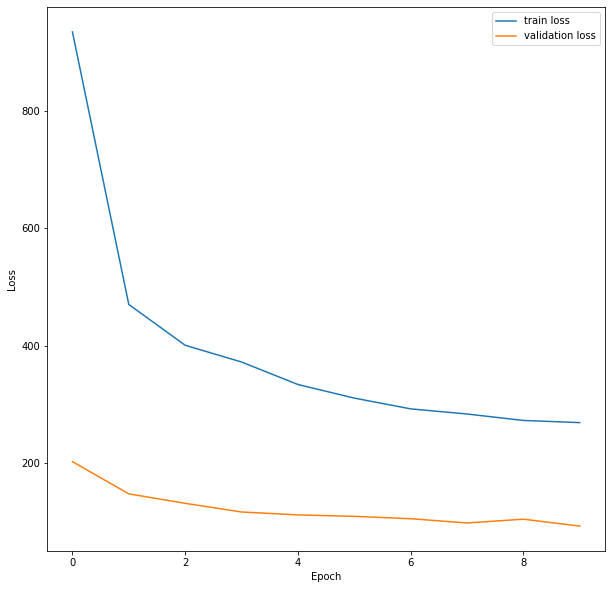

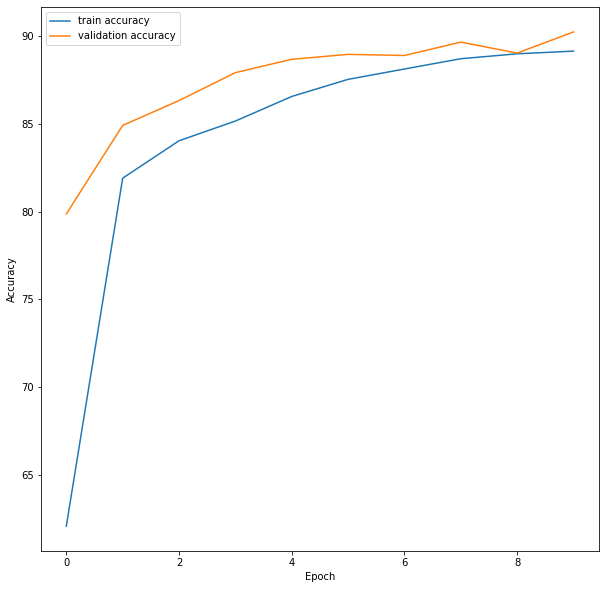

In [7]:
# mAlexNet (56,56)

# did not change the architecture, but changed the kernel size and channels


class MNIST_2D(nn.Module):
    def __init__(self,input_size,num_classes,weight_bit_width,act_bit_width):
        super(MNIST_2D,self).__init__()
        
        self.cnn1 = QuantConv2d(in_channels=input_size,out_channels=16,kernel_size=3,
                                padding=1,bias=False,weight_bit_width=weight_bit_width)
        self.bn_1 = nn.BatchNorm2d(16)
        self.relu1 = QuantReLU(bit_width=act_bit_width)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn2 = QuantConv2d(in_channels=16,out_channels=20,kernel_size=3,
                                padding=1,bias=False,weight_bit_width=weight_bit_width)
        self.bn_2 = nn.BatchNorm2d(20)
        self.relu2 = QuantReLU(bit_width=act_bit_width)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn3 = QuantConv2d(in_channels=20,out_channels=30,kernel_size=3, stride=(3,3),
                               padding=2,bias=False,weight_bit_width=weight_bit_width)
        self.relu3 = QuantReLU(bit_width=act_bit_width)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=None)

        self.drop1 = QuantDropout(p=0.5)
                                  
        self.fc1 = QuantLinear(3*3*30,2*30,bias=False,weight_bit_width=weight_bit_width)
        self.relu4 = QuantReLU(bit_width=act_bit_width)
        
        self.fc2 = QuantLinear(30*2,num_classes,bias=False,weight_bit_width=weight_bit_width)
        
    def forward(self,x):
        x = self.maxpool1(self.relu1(self.bn_1(self.cnn1(x))))
        x = self.maxpool2(self.relu2(self.bn_2(self.cnn2(x))))
        x = self.maxpool3(self.relu3(self.cnn3(x)))
        
        x = x.view(x.size(0),-1)
        x = self.drop1(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
input_size = 1 # 3 input layers for RGB image
num_classes = n_classes
weight_bit_width = 2
act_bit_width = 2

brevitas_model = MNIST_2D(input_size=input_size,num_classes=num_classes,
                                    weight_bit_width=weight_bit_width,act_bit_width=act_bit_width)

LEARNING_RATE = 0.0004
optimizer = optim.Adam(brevitas_model.parameters(),lr = LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

train_loader, test_loader = data_loader(root=path1)

EPOCHS=10
lr_reduce=30
trained_classifier = train_model(CNNmodel=brevitas_model,epochs=EPOCHS,
                                train_loader=train_loader, test_loader=test_loader,
                                criterion = criterion,optimizer = optimizer, 
                                Batch_Size = BATCH_SIZE,print_every = 5, 
                                LEARNING_RATE=LEARNING_RATE, lr_reduce=lr_reduce,
                                verbose=True,plot_results=True)

torch.save(brevitas_model.state_dict(),'./multi_model_test/save_model/model_2D_parameter_56_56_s.pth')

export_onnx_path="./multi_model_test/save_model/model_2D_56_56_s.onnx"
input_shape=(1,1,56,56)
bo.export_finn_onnx(brevitas_model, input_shape, export_onnx_path)

Training for 10 epochs...



Epoch 1/10: train loss: 877.6829 | acc: 64.9766%|   validation loss: 166.5134 | acc: 83.1771% 

Epoch 6/10: train loss: 254.9952 | acc: 89.8750%|   validation loss: 86.2804 | acc: 90.8854% 

Final Accuracy:92.8542%

Finished Training  | Time:627.0539803504944


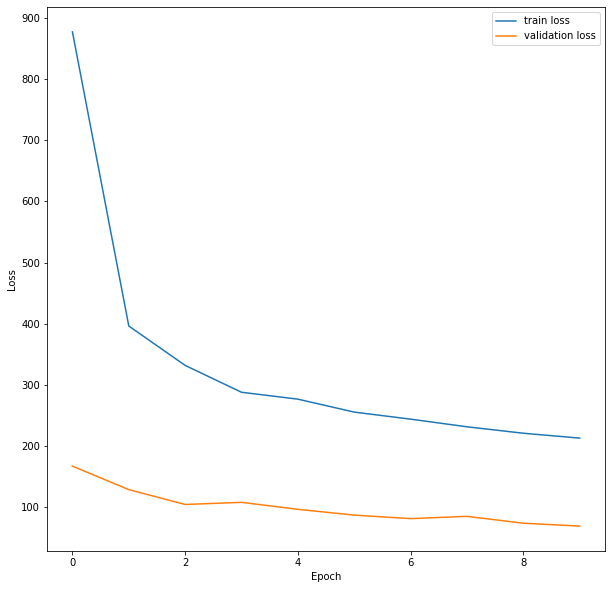

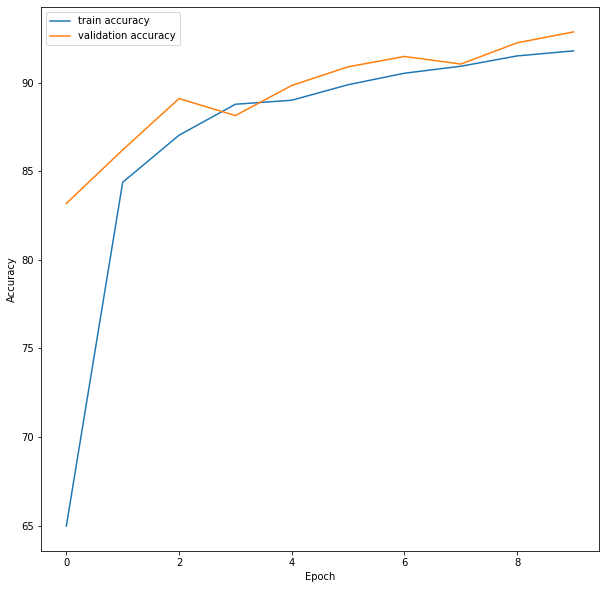

In [11]:
# mAlexNet (42,42)

# did not change the architecture, but changed the kernel size and channels


class MNIST_2D(nn.Module):
    def __init__(self,input_size,num_classes,weight_bit_width,act_bit_width):
        super(MNIST_2D,self).__init__()
        
        self.cnn1 = QuantConv2d(in_channels=input_size,out_channels=16,kernel_size=3,
                                padding=0,bias=False,weight_bit_width=weight_bit_width)
        self.bn_1 = nn.BatchNorm2d(16)
        self.relu1 = QuantReLU(bit_width=act_bit_width)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn2 = QuantConv2d(in_channels=16,out_channels=20,kernel_size=3,
                                padding=1,bias=False,weight_bit_width=weight_bit_width)
        self.bn_2 = nn.BatchNorm2d(20)
        self.relu2 = QuantReLU(bit_width=act_bit_width)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn3 = QuantConv2d(in_channels=20,out_channels=30,kernel_size=3, stride=(3,3),
                               padding=1,bias=False,weight_bit_width=weight_bit_width)
        self.relu3 = QuantReLU(bit_width=act_bit_width)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=None)

        self.drop1 = QuantDropout(p=0.5)
                                  
        self.fc1 = QuantLinear(2*2*30,2*30,bias=False,weight_bit_width=weight_bit_width)
        self.relu4 = QuantReLU(bit_width=act_bit_width)
        
        self.fc2 = QuantLinear(30*2,num_classes,bias=False,weight_bit_width=weight_bit_width)
        
    def forward(self,x):
        x = self.maxpool1(self.relu1(self.bn_1(self.cnn1(x))))
        x = self.maxpool2(self.relu2(self.bn_2(self.cnn2(x))))
        x = self.maxpool3(self.relu3(self.cnn3(x)))
        
        x = x.view(x.size(0),-1)
        x = self.drop1(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
input_size = 1 # 3 input layers for RGB image
num_classes = n_classes
weight_bit_width = 2
act_bit_width = 2

brevitas_model = MNIST_2D(input_size=input_size,num_classes=num_classes,
                                    weight_bit_width=weight_bit_width,act_bit_width=act_bit_width)

LEARNING_RATE = 0.0004
optimizer = optim.Adam(brevitas_model.parameters(),lr = LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

train_loader, test_loader = data_loader(root=path1)

EPOCHS=10
lr_reduce=30
trained_classifier = train_model(CNNmodel=brevitas_model,epochs=EPOCHS,
                                train_loader=train_loader, test_loader=test_loader,
                                criterion = criterion,optimizer = optimizer, 
                                Batch_Size = BATCH_SIZE,print_every = 5, 
                                LEARNING_RATE=LEARNING_RATE, lr_reduce=lr_reduce,
                                verbose=True,plot_results=True)

torch.save(brevitas_model.state_dict(),'./multi_model_test/save_model/model_2D_parameter_42_42_s.pth')

export_onnx_path="./multi_model_test/save_model/model_2D_42_42_s.onnx"
input_shape=(1,1,42,42)
bo.export_finn_onnx(brevitas_model, input_shape, export_onnx_path)

Training for 10 epochs...



Epoch 1/10: train loss: 1254.4964 | acc: 46.1992%|   validation loss: 310.3330 | acc: 65.0104% 

Epoch 6/10: train loss: 460.0364 | acc: 81.1523%|   validation loss: 150.8432 | acc: 84.0104% 

Final Accuracy:82.7500%

Finished Training  | Time:402.7782735824585


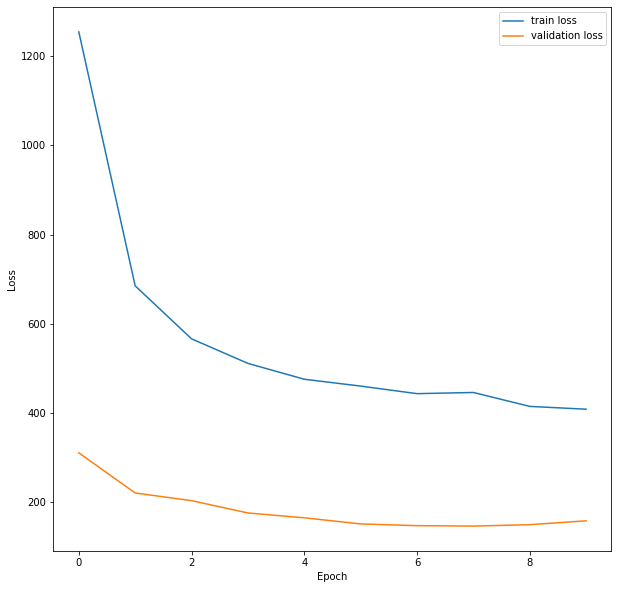

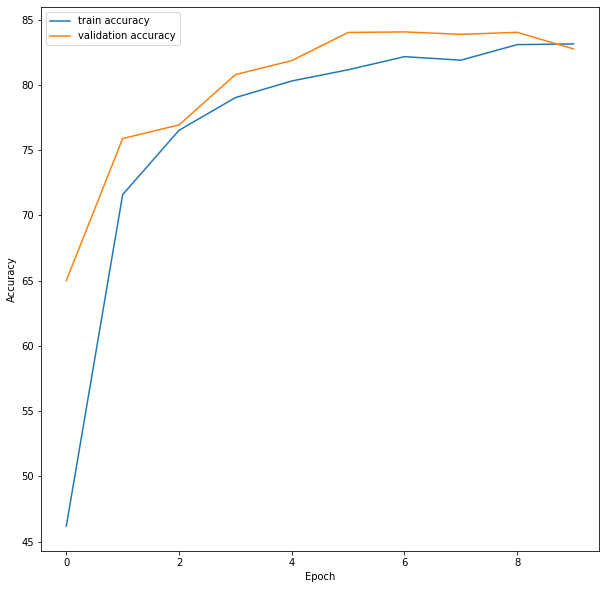

In [15]:
# mAlexNet (28,28)

# did not change the architecture, but changed the kernel size and channels


class MNIST_2D(nn.Module):
    def __init__(self,input_size,num_classes,weight_bit_width,act_bit_width):
        super(MNIST_2D,self).__init__()
        
        self.cnn1 = QuantConv2d(in_channels=input_size,out_channels=16,kernel_size=3,
                                padding=1,bias=False,weight_bit_width=weight_bit_width)
        self.bn_1 = nn.BatchNorm2d(16)
        self.relu1 = QuantReLU(bit_width=act_bit_width)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn2 = QuantConv2d(in_channels=16,out_channels=20,kernel_size=3,
                                padding=0,bias=False,weight_bit_width=weight_bit_width)
        self.bn_2 = nn.BatchNorm2d(20)
        self.relu2 = QuantReLU(bit_width=act_bit_width)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=None)
        
        self.cnn3 = QuantConv2d(in_channels=20,out_channels=30,kernel_size=3, stride=(3,3),
                               padding=0,bias=False,weight_bit_width=weight_bit_width)
        self.relu3 = QuantReLU(bit_width=act_bit_width)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=None)

        self.drop1 = QuantDropout(p=0.5)
                                  
        self.fc1 = QuantLinear(1*1*30,2*30,bias=False,weight_bit_width=weight_bit_width)
        self.relu4 = QuantReLU(bit_width=act_bit_width)
        
        self.fc2 = QuantLinear(30*2,num_classes,bias=False,weight_bit_width=weight_bit_width)
        
    def forward(self,x):
        x = self.maxpool1(self.relu1(self.bn_1(self.cnn1(x))))
        x = self.maxpool2(self.relu2(self.bn_2(self.cnn2(x))))
        x = self.maxpool3(self.relu3(self.cnn3(x)))
        
        x = x.view(x.size(0),-1)
        x = self.drop1(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
input_size = 1 # 3 input layers for RGB image
num_classes = n_classes
weight_bit_width = 2
act_bit_width = 2

brevitas_model = MNIST_2D(input_size=input_size,num_classes=num_classes,
                                    weight_bit_width=weight_bit_width,act_bit_width=act_bit_width)

LEARNING_RATE = 0.0004
optimizer = optim.Adam(brevitas_model.parameters(),lr = LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

train_loader, test_loader = data_loader(root=path1)

EPOCHS=10
lr_reduce=30
trained_classifier = train_model(CNNmodel=brevitas_model,epochs=EPOCHS,
                                train_loader=train_loader, test_loader=test_loader,
                                criterion = criterion,optimizer = optimizer, 
                                Batch_Size = BATCH_SIZE,print_every = 5, 
                                LEARNING_RATE=LEARNING_RATE, lr_reduce=lr_reduce,
                                verbose=True,plot_results=True)

torch.save(brevitas_model.state_dict(),'./multi_model_test/save_model/model_2D_parameter_28_28_s.pth')

export_onnx_path="./multi_model_test/save_model/model_2D_28_28_s.onnx"
input_shape=(1,1,28,28)
bo.export_finn_onnx(brevitas_model, input_shape, export_onnx_path)